In [2]:
import pandas as pd
import numpy as np
import requests
import shelve
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import re
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
import statsmodels 
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.runs import runstest_1samp

In [4]:
user="Lilian"
years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
#user in personal pc1 <- "asus"

In [5]:
class NDCATCProcessor:

    def __init__(self, year, base_path=None):
        self.year = year
        self.base_path = base_path or rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        self.df_cleaned = None
        self.df_merged = None
        self.atc_mapping = None
        
    def clean_sdud_data(self):

        csv_file = os.path.join(self.base_path, f"SDUD\\SDUD{self.year}.csv")
        print(f"Reading CSV: {csv_file}")
        
        df = pd.read_csv(csv_file, dtype={'NDC': 'object'})
        print(f"Initial rows: {len(df):,}")
        
        # Filter data
        df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions']) #dropping na values
        df_filtered = df_filtered[df_filtered['State'] != 'XX']
        
        print(f"After cleaning: {len(df_filtered):,} rows, {df_filtered['NDC'].nunique():,} unique NDCs")
        
        self.df_cleaned = df_filtered
        return self.df_cleaned
    
    def adding_key(self):
        if self.df_cleaned is None:
            raise ValueError("Run clean_sdud_data() first")
        
        self.df_cleaned['record_id'] = (
            self.df_cleaned['State'].astype(str) + "_" +
            self.df_cleaned['Year'].astype(str) + "_" +
            self.df_cleaned['Quarter'].astype(str) + "_" +
            self.df_cleaned['Utilization Type'].astype(str) + "_" +
            self.df_cleaned['NDC'].astype(str)
        )
        
        print(f"Created {len(self.df_cleaned):,} record IDs")
        return self.df_cleaned
    
    def generate_ndc_txt(self, output_filename=None):
        if 'record_id' not in self.df_cleaned.columns:
            raise ValueError("Run adding_key() first")
            
        output_filename = output_filename or f"NDCNEW_{self.year}.txt"
        output_path = os.path.join(self.base_path, f"ATC\\text_files\\{output_filename}")
        
        unique_pairs = self.df_cleaned[['NDC', 'record_id']].drop_duplicates()
        
        with open(output_path, 'w') as f:
            f.write("NDC\trecord_id\n")
            for _, row in unique_pairs.iterrows():
                f.write(f"{row['NDC']}\t{row['record_id']}\n")
        
        print(f"Exported {unique_pairs['record_id'].nunique():,} unique records to {output_path}")
        return output_path
    
    def analyze_atc4_mapping(self):

        if 'record_id' not in self.df_cleaned.columns:
            raise ValueError("Run adding_key() first")
            
        atc4_path = os.path.join(self.base_path, f"ATC\\ATC4_classes\\NDCNEW_{self.year}_ATC4_classes.csv")
        
        # Load ATC4 mapping
        df_atc4 = pd.read_csv(atc4_path, dtype={'NDC': 'object', 'record_id': 'string'})
        df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
        
        print(f"ATC4 file: {len(df_atc4):,} rows, {df_atc4['NDC'].nunique():,} unique NDCs")
        
        # Ensure consistent types
        self.df_cleaned['record_id'] = self.df_cleaned['record_id'].astype('string')
        self.df_cleaned['NDC'] = self.df_cleaned['NDC'].astype('object')
        
        # Merge on both record_id and NDC
        self.atc_mapping = pd.merge(
            self.df_cleaned,
            df_atc4[['record_id', 'NDC', 'ATC4 Class']],
            on=['record_id', 'NDC'],
            how='left'
        )
        #deduplication after merge by record_id
        before_count=len(self.atc_mapping) 
        self.atc_mapping=self.atc_mapping.drop_duplicates(subset='record_id', keep='first')
        
        total = len(self.atc_mapping)
     
        mapped = self.atc_mapping['ATC4 Class'].notna().sum()
        print(f"Merged: {total:,} records, {mapped:,} with ATC4 ({mapped/total*100:.1f}%)")
        
        missing = total - mapped
        if missing > 0:
            print(f"Missing: {missing:,} records, {self.atc_mapping[self.atc_mapping['ATC4 Class'].isna()]['NDC'].nunique():,} unique NDCs")
        
        return self.atc_mapping
    
    def analyze_atc_distribution(self, level='ATC3'):

        if self.atc_mapping is None:
            raise ValueError("Run analyze_atc4_mapping() first")
        
        records = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()].copy()
        
        if len(records) == 0:
            print("No records with valid ATC4 mappings.")
            return None
        
        # Create ATC level column if needed
        if level == 'ATC3':
            records['ATC3 Class'] = records['ATC4 Class'].str[:4]
            class_col = 'ATC3 Class'
        elif level == 'ATC2':
            records['ATC2 Class'] = records['ATC4 Class'].str[:3]
            class_col = 'ATC2 Class'
        else:
            class_col = 'ATC4 Class'
        
        # Count classes per record_id
        per_record = records.groupby('record_id')[class_col].nunique().reset_index()
        per_record.columns = ['record_id', 'num_classes']
        
        distribution = per_record['num_classes'].value_counts().sort_index()
        
        print(f"\n{level} CLASSES PER RECORD_ID:")
        for n_classes, count in distribution.items():
            pct = (count / len(per_record)) * 100
            print(f"  {n_classes} class(es): {count:,} records ({pct:.1f}%)")
        
        print(f"\nSummary:")
        print(f"  Avg {level} per record: {per_record['num_classes'].mean():.2f}")
        print(f"  Max {level} per record: {per_record['num_classes'].max()}")
        
        return per_record

    def fetch_atc_names(self, cache_path=None):
        """Fetch ATC class names (ATC4, ATC3, ATC2) from RxNav API."""
        if self.atc_mapping is None:
            raise ValueError("Must run analyze_atc4_mapping() first")
        
        if cache_path is None:
            cache_path = os.path.join(self.base_path, "ATC\\cache_files\\atc_names_cache")
        
        print(f"\n{'='*60}")
        print("FETCHING ATC CLASS NAMES")
        print(f"{'='*60}")
        print(f"Using cache: {cache_path}")
        
        # Get only records with valid ATC4 mappings
        df_with_atc = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()].copy()
        
        # Create ATC3 and ATC2 columns from ATC4
        print("\nCreating ATC3 and ATC2 columns from ATC4...")
        df_with_atc['ATC3 Class'] = df_with_atc['ATC4 Class'].str[:4]
        df_with_atc['ATC2 Class'] = df_with_atc['ATC4 Class'].str[:3]
        
        # Get unique codes for each level
        unique_atc4 = df_with_atc['ATC4 Class'].dropna().unique()
        unique_atc3 = df_with_atc['ATC3 Class'].dropna().unique()
        unique_atc2 = df_with_atc['ATC2 Class'].dropna().unique()
        
        # Filter out invalid codes
        unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
        unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        
        print(f"\nUnique codes to fetch:")
        print(f"  ATC4: {len(unique_atc4)}")
        print(f"  ATC3: {len(unique_atc3)}")
        print(f"  ATC2: {len(unique_atc2)}")
        
        # Build mappings
        atc4_names = {}
        atc3_names = {}
        atc2_names = {}
        
        with shelve.open(cache_path) as cache:
            start_time = datetime.now()
            
            print("\nFetching ATC4 names...")
            for code in unique_atc4:
                atc4_names[code] = self._get_atc_name(code, cache)
            
            print("Fetching ATC3 names...")
            for code in unique_atc3:
                atc3_names[code] = self._get_atc_name(code, cache)
            
            print("Fetching ATC2 names...")
            for code in unique_atc2:
                atc2_names[code] = self._get_atc_name(code, cache)
            
            print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
        
        # Apply names to all records in atc_mapping
        print("\nApplying names to dataframe...")
        self.atc_mapping['ATC3 Class'] = self.atc_mapping['ATC4 Class'].str[:4]
        self.atc_mapping['ATC2 Class'] = self.atc_mapping['ATC4 Class'].str[:3]
        
        self.atc_mapping['ATC4_Name'] = self.atc_mapping['ATC4 Class'].map(atc4_names).fillna('')
        self.atc_mapping['ATC3_Name'] = self.atc_mapping['ATC3 Class'].map(atc3_names).fillna('')
        self.atc_mapping['ATC2_Name'] = self.atc_mapping['ATC2 Class'].map(atc2_names).fillna('')
        
        print(f"\nATC names added successfully!")
        print("\nSample output:")
        sample = self.atc_mapping[self.atc_mapping['ATC4 Class'].notna()][['NDC', 'record_id', 'ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(5)
        print(sample.to_string())
        
        return self.atc_mapping
    
    def prepare_final_dataframe(self):

        if self.atc_mapping is None:
            raise ValueError("Run fetch_atc_names() first")
        
        self.df_merged = self.atc_mapping.copy()
        
        # Scale units
        self.df_merged['Units Reimbursed'] = self.df_merged['Units Reimbursed'] / 1e9
        self.df_merged['Number of Prescriptions'] = self.df_merged['Number of Prescriptions'] / 1e6
        
        total = len(self.df_merged)
        mapped = self.df_merged['ATC4 Class'].notna().sum()
        
        print(f"\nFinal Statistics:")
        print(f"  Records: {total:,} ({mapped:,} with ATC4, {mapped/total*100:.1f}%)")
        print(f"  Units Reimbursed: {self.df_merged['Units Reimbursed'].sum():.2f} Billion")
        print(f"  Prescriptions: {self.df_merged['Number of Prescriptions'].sum():.2f} Million")
        
        return self.df_merged
    
    def _get_atc_name(self, atc_code, cache):
        """Helper: Fetch ATC name from RxNav API with caching."""
        cache_key = f"atc_name:{atc_code}"
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
                concepts = data['rxclassMinConceptList']['rxclassMinConcept']
                if concepts:
                    name = concepts[0].get('className', '')
                    cache[cache_key] = name
                    return name
            
            cache[cache_key] = ''
            return ''
            
        except Exception as e:
            print(f"Error retrieving {atc_code}: {e}")
            cache[cache_key] = ''
            return ''

    def export_merged_data(self, output_filename=None, show_details=True):

        if self.df_merged is None:
            raise ValueError("Run prepare_final_dataframe() first")
            
        output_filename = output_filename or f"merged_NEWdata_{self.year}.csv"
        output_path = os.path.join(self.base_path, f"ATC\\merged_data\\{output_filename}")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Check duplicates
        initial_count = len(self.df_merged)
        duplicate_count = self.df_merged['record_id'].duplicated().sum()
        
        print(f"\nDeduplication Check:")
        print(f"  Before: {initial_count:,} rows")
        print(f"  Duplicates: {duplicate_count:,}")
        
        # Show sample duplicates if requested
        if show_details and duplicate_count > 0:
            dup_records = self.df_merged[self.df_merged['record_id'].duplicated(keep=False)].sort_values('record_id')
            sample_ids = dup_records['record_id'].unique()[:2]
            
            print(f"\nSample duplicate record_ids:")
            for rid in sample_ids:
                sample = self.df_merged[self.df_merged['record_id'] == rid][
                    ['record_id', 'NDC', 'State', 'ATC4 Class', 'ATC2 Class']
                ]
                print(f"\n{rid}:")
                print(sample.to_string(index=False))
        
        # Deduplicate and export
        df_final = self.df_merged.drop_duplicates(subset='record_id', keep='first')
        df_final.to_csv(output_path, index=False)
        
        print(f"\n  After: {len(df_final):,} rows")
        print(f"  Removed: {initial_count - len(df_final):,}")
        print(f"\nExported to: {output_path}")

        #Showing final atc class mapping in %
        final_count = len(df_final)
        final_mapped_records = df_final['ATC4 Class'].notna().sum()
        final_unmapped_records = final_count - final_mapped_records
        final_mapped_ndcs=df_final[df_final['ATC4 Class'].notna()]['NDC'].nunique()
        final_unmapped_ndcs=df_final['NDC'].nunique()
        
        # Aggregate metrics
        agg = df_final.groupby('record_id').agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        })
        
        print(f"\nAggregated Totals:")
        print(f"  Units Reimbursed: {agg['Units Reimbursed'].sum():.3f} Billion")
        print(f"  Number of Prescriptions: {agg['Number of Prescriptions'].sum():3f} Million")
        
        return output_path
    
    def export_unscaled_data(self, output_filename=None, show_details=True):
        """Export merged data without scaling units."""
        if self.atc_mapping is None:
            raise ValueError("Run fetch_atc_names() first")
        
        output_filename = output_filename or f"MUD_{self.year}.csv"
        output_path = os.path.join(self.base_path, f"ATC\\merged_data\\unscaled_data\\{output_filename}")
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Use atc_mapping directly (no scaling)
        df_unscaled = self.atc_mapping.copy()
        
        # Check duplicates
        initial_count = len(df_unscaled)
        duplicate_count = df_unscaled['record_id'].duplicated().sum()
        
        print(f"\nDeduplication Check:")
        print(f"  Before: {initial_count:,} rows")
        print(f"  Duplicates: {duplicate_count:,}")
        
        # Show sample duplicates if requested
        if show_details and duplicate_count > 0:
            dup_records = df_unscaled[df_unscaled['record_id'].duplicated(keep=False)].sort_values('record_id')
            sample_ids = dup_records['record_id'].unique()[:2]
            
            print(f"\nSample duplicate record_ids:")
            for rid in sample_ids:
                sample = df_unscaled[df_unscaled['record_id'] == rid][
                    ['record_id', 'NDC', 'State', 'ATC4 Class', 'ATC2 Class']
                ]
                print(f"\n{rid}:")
                print(sample.to_string(index=False))
        
        # Deduplicate and export
        df_final = df_unscaled.drop_duplicates(subset='record_id', keep='first')
        df_final.to_csv(output_path, index=False)
        
        print(f"\n  After: {len(df_final):,} rows")
        print(f"  Removed: {initial_count - len(df_final):,}")
        print(f"\nExported to: {output_path}")
        
        # Show final ATC class mapping
        final_count = len(df_final)
        final_mapped_records = df_final['ATC4 Class'].notna().sum()
        
        # Aggregate metrics (unscaled)
        agg = df_final.groupby('record_id').agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        })
        
        print(f"\nAggregated Totals (Unscaled):")
        print(f"  Units Reimbursed: {agg['Units Reimbursed'].sum():,.0f}")
        print(f"  Number of Prescriptions: {agg['Number of Prescriptions'].sum():,.0f}")
        print(f"  Mapped Records: {final_mapped_records:,} ({final_mapped_records/final_count*100:.1f}%)")
        
        return output_path

In [6]:
class NDCATC_overview:

    @staticmethod
    def create_multi_year_distribution_analysis(years_list, base_path=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
            
        print("Creating Multi-Year ATC Distribution Analysis...")
        print("="*70)
        
        results = {
            'ATC4_1_class': {}, 'ATC4_2_classes': {}, 'ATC4_3+_classes': {},
            'ATC3_1_class': {}, 'ATC3_2_classes': {}, 'ATC3_3+_classes': {},
            'ATC2_1_class': {}, 'ATC2_2_classes': {}, 'ATC2_3+_classes': {}
        }
        
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                # Load the pre-processed CSV file
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                if records.empty:
                    print("No ATC records")
                    for key in results.keys():
                        results[key][year] = "N/A"
                    continue
                    
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                records['ATC3 Class'] = records['ATC4 Class'].str[:4]
                
                # Calculate distributions for each level
                for level, col in [('ATC4', 'ATC4 Class'), ('ATC3', 'ATC3 Class'), ('ATC2', 'ATC2 Class')]:
                    per_record = records.groupby('record_id')[col].nunique()
                    dist = per_record.value_counts().sort_index()
                    total = len(per_record)
                    
                    results[f'{level}_1_class'][year] = f"{(dist.get(1, 0) / total * 100):.1f}%"
                    results[f'{level}_2_classes'][year] = f"{(dist.get(2, 0) / total * 100):.1f}%"
                    results[f'{level}_3+_classes'][year] = f"{(dist[dist.index >= 3].sum() / total * 100):.1f}%"
                
                print("✓")
            except FileNotFoundError:
                print(f"✗ File not found: {csv_path}")
                for key in results.keys():
                    results[key][year] = "N/A"
            except Exception as e:
                print(f"✗ Error: {e}")
                for key in results.keys():
                    results[key][year] = "N/A"
        
        df_percentages = pd.DataFrame(results).T
        print(f"\nATC DISTRIBUTION PERCENTAGES ACROSS YEARS")
        print("="*60)
        print(df_percentages)
        return df_percentages
    
    @staticmethod
    def analyze_general_atc_overview_by_state(years_list, base_path=None, state_filter=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"

        if state_filter:
            if isinstance(state_filter, str):
                state_filter = [state_filter]
            print(f"Creating ATC2 & ATC3 Overview by State for: {', '.join(state_filter)}")
        else:
            print("Creating ATC2 & ATC3 Overview by State (All States)")
        print("="*78)
        
        # Results will be organized by state
        state_results = {}
        all_states = set()
        
        # Collect data for all years first
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                if records.empty:
                    print("No ATC records")
                    continue
                
                # Filter by state if specified
                if state_filter:
                    records = records[records['State'].isin(state_filter)]
                    if records.empty:
                        print(f"No records for states {state_filter}")
                        continue
                    states_to_process = state_filter
                else:
                    states_to_process = records['State'].unique()
                    all_states.update(states_to_process)
                
                for state in states_to_process:
                    state_records = records[records['State'] == state]
                    if state_records.empty:
                        continue
                    
                    # Initialize state data structure
                    if state not in state_results:
                        state_results[state] = {
                            'atc2_year_results': {},
                            'atc3_year_results': {}
                        }
                    
                    # ATC2 summary for this state
                    pairs2 = state_records[['record_id', 'NDC', 'ATC2 Class']].drop_duplicates()
                    atc2_summary = pairs2.groupby('ATC2 Class').agg(
                        Unique_NDCs=('NDC', 'nunique'),
                        Total_Records=('record_id', 'nunique')
                    ).sort_values('Unique_NDCs', ascending=False)
                    atc2_summary['Percentage_of_NDCs'] = (
                        atc2_summary['Unique_NDCs'] / pairs2['NDC'].nunique() * 100
                    ).round(1)
                    
                    # ATC3 summary for this state
                    pairs3 = state_records[['record_id', 'NDC', 'ATC3 Class']].drop_duplicates()
                    atc3_summary = pairs3.groupby('ATC3 Class').agg(
                        Unique_NDCs=('NDC', 'nunique'),
                        Total_Records=('record_id', 'nunique')
                    ).sort_values('Unique_NDCs', ascending=False)
                    atc3_summary['Percentage_of_NDCs'] = (
                        atc3_summary['Unique_NDCs'] / pairs3['NDC'].nunique() * 100
                    ).round(1)
                    
                    state_results[state]['atc2_year_results'][year] = atc2_summary
                    state_results[state]['atc3_year_results'][year] = atc3_summary
                
                processed_states = len([s for s in states_to_process if s in state_results])
                print(f"✓ (States: {processed_states})")
                
            except FileNotFoundError:
                print(f"✗ File not found")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # Process each state with the same format as original method
        final_state_results = {}
        
        states_to_analyze = state_filter if state_filter else sorted(all_states)
        
        for state in states_to_analyze:
            if state not in state_results:
                continue
                
            print(f"\n" + "="*60)
            print(f"PROCESSING STATE: {state}")
            print("="*60)
            
            atc2_year_results = state_results[state]['atc2_year_results']
            atc3_year_results = state_results[state]['atc3_year_results']
            
            # Print summaries for this state (same format as original)
            print(f"\nUNIQUE NDCs PER ATC2 CLASS BY YEAR - {state}")
            print("="*50)
            for year in years_list:
                if year in atc2_year_results and not atc2_year_results[year].empty:
                    print(f"\n{year}: {len(atc2_year_results[year])} classes, "
                        f"{atc2_year_results[year]['Unique_NDCs'].sum():,} total NDCs")
                    print("Top 10:")
                    print(atc2_year_results[year].head(10))
            
            print(f"\nUNIQUE NDCs PER ATC3 CLASS BY YEAR - {state}")
            print("="*50)
            for year in years_list:
                if year in atc3_year_results and not atc3_year_results[year].empty:
                    print(f"\n{year}: {len(atc3_year_results[year])} classes, "
                        f"{atc3_year_results[year]['Unique_NDCs'].sum():,} total NDCs")
                    print("Top 10:")
                    print(atc3_year_results[year].head(10))
            
            # Build comparison tables (same logic as original)
            def build_comparison(year_tables):
                all_classes = set()
                for tbl in year_tables.values():
                    if not tbl.empty:
                        all_classes.update(tbl.index.tolist())
                comp = {cls: {y: int(year_tables[y].loc[cls, 'Unique_NDCs']) 
                            if y in year_tables and not year_tables[y].empty and cls in year_tables[y].index else 0
                            for y in years_list}
                        for cls in sorted(all_classes)}
                df = pd.DataFrame(comp).T
                return df.loc[df.sum(axis=1).sort_values(ascending=False).index]
            
            atc2_comparison = build_comparison(atc2_year_results)
            atc3_comparison = build_comparison(atc3_year_results)
            
            # Create cumulative frequency tables (same logic as original)
            def create_cumulative_frequency_table(comparison_df, level_name):
                total_ndcs = comparison_df.sum(axis=1).sort_values(ascending=False)
                
                freq_table = pd.DataFrame({
                    'ATC_Class': total_ndcs.index,
                    'Total_Unique_NDCs': total_ndcs.values,
                    'Percentage': (total_ndcs.values / total_ndcs.sum() * 100).round(2)
                })
                
                freq_table['Cumulative_NDCs'] = freq_table['Total_Unique_NDCs'].cumsum()
                freq_table['Cumulative_Percentage'] = freq_table['Percentage'].cumsum().round(2)
                
                freq_table.reset_index(drop=True, inplace=True)
                freq_table.index = freq_table.index + 1
                
                return freq_table
            
            atc2_freq_table = create_cumulative_frequency_table(atc2_comparison, 'ATC2')
            atc3_freq_table = create_cumulative_frequency_table(atc3_comparison, 'ATC3')
            
            # Store results for this state
            final_state_results[state] = {
                'atc2_year_results': atc2_year_results,
                'atc3_year_results': atc3_year_results,
                'atc2_comparison': atc2_comparison,
                'atc3_comparison': atc3_comparison,
                'atc2_freq_table': atc2_freq_table,
                'atc3_freq_table': atc3_freq_table
            }
        
        return final_state_results
    
    @staticmethod
    def get_atc_ndc_details(year, top_n=10, base_path=None):
    
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
            
        print(f"Analyzing ATC-NDC details for {year}...")
        print("="*60)
        
        try:
            # Load the pre-processed CSV file
            csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
            df_merged = pd.read_csv(csv_path)
            
            records = df_merged[df_merged['ATC4 Class'].notna()].copy()
            if records.empty:
                print("No records with ATC mapping")
                return pd.DataFrame(), pd.DataFrame()
                
            records['ATC2 Class'] = records['ATC4 Class'].str[:3]
            records['ATC3 Class'] = records['ATC4 Class'].str[:4]
            
            # ATC2 details
            atc2_details = records.groupby('ATC2 Class').agg(
                Unique_NDCs=('NDC', 'nunique'),
                Total_Records=('record_id', 'nunique')
            ).sort_values('Unique_NDCs', ascending=False).head(top_n)
            
            # ATC3 details
            atc3_details = records.groupby('ATC3 Class').agg(
                Unique_NDCs=('NDC', 'nunique'),
                Total_Records=('record_id', 'nunique')
            ).sort_values('Unique_NDCs', ascending=False).head(top_n)
            
            print(f"\nTop {top_n} ATC2 Classes:")
            print(atc2_details)
            print(f"\nTop {top_n} ATC3 Classes:")
            print(atc3_details)
            
            return atc2_details, atc3_details
            
        except FileNotFoundError:
            print(f"✗ File not found: {csv_path}")
            return pd.DataFrame(), pd.DataFrame()
        except Exception as e:
            print(f"✗ Error: {e}")
            return pd.DataFrame(), pd.DataFrame()
    
    @staticmethod
    def export_cumulative_frequency_excel(years_list, level='ATC2', base_path=None, output_filename=None, 
                                          include_ndc_counts=True, by_state=False, state_filter=None):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        # Print header
        if by_state:
            states_msg = ', '.join(state_filter) if state_filter else 'All States'
            print(f"Creating {level} Cumulative Frequency Analysis Excel for States: {states_msg}")
        else:
            print(f"Creating {level} Cumulative Frequency Analysis Excel...")
        print("="*70)
        
        # Helper function to create ATC level column
        def create_atc_level_column(df, level):
            if level == 'ATC2':
                return df['ATC4 Class'].str[:3]
            elif level == 'ATC3':
                return df['ATC4 Class'].str[:4]
            else:  # ATC4
                return df['ATC4 Class']
        
        # Helper function to get name mapping
        def get_name_mapping(records, level):
            name_col_map = {'ATC2': 'ATC2_Name', 'ATC3': 'ATC3_Name', 'ATC4': 'ATC4_Name'}
            name_col = name_col_map.get(level)
            
            if name_col and name_col in records.columns:
                return records[['ATC_Level', name_col]].drop_duplicates().set_index('ATC_Level')[name_col].to_dict()
            return {}
        
        # Helper function to process year data
        def process_year_data(csv_path, level, state_filter=None):
            try:
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                
                if records.empty:
                    return None, None, None, None
                
                # Filter by state if needed
                if state_filter:
                    records = records[records['State'].isin(state_filter)]
                    if records.empty:
                        return None, None, None, None
                
                records['ATC_Level'] = create_atc_level_column(records, level)
                name_mapping = get_name_mapping(records, level)
                
                # Aggregate financial data
                financial = records.groupby('ATC_Level').agg(
                    Units_Reimbursed=('Units Reimbursed', 'sum'),
                    Number_of_Prescriptions=('Number of Prescriptions', 'sum')
                )
                
                # Count unique NDCs
                ndc_counts = records.groupby('ATC_Level').agg(
                    Unique_NDCs=('NDC', 'nunique')
                )
                
                states_processed = records['State'].nunique() if 'State' in records.columns else 1
                
                return financial, ndc_counts, name_mapping, states_processed
                
            except Exception as e:
                print(f"Error processing file: {e}")
                return None, None, None, None
        
        # Collect data for all years
        if by_state:
            state_data = {}  # {state: {year: (financial, ndc_counts, name_mapping)}}
            all_states = set()
        else:
            year_results = {}
            ndc_counts = {}
            name_mapping = {}
        
        # Process each year
        for year in years_list:
            print(f"Processing {year}...", end=" ")
            csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
            
            if by_state:
                # Load full data first
                try:
                    df = pd.read_csv(csv_path)
                    records = df[df['ATC4 Class'].notna()].copy()
                    
                    if state_filter:
                        states_to_process = state_filter if isinstance(state_filter, list) else [state_filter]
                    else:
                        states_to_process = records['State'].unique()
                        all_states.update(states_to_process)
                    
                    for state in states_to_process:
                        financial, ndcs, names, _ = process_year_data(csv_path, level, [state])
                        
                        if financial is not None:
                            if state not in state_data:
                                state_data[state] = {}
                            state_data[state][year] = (financial, ndcs, names)
                    
                    print(f"✓ (States: {len(states_to_process)})")
                except:
                    print("✗")
            else:
                financial, ndcs, names, _ = process_year_data(csv_path, level)
                
                if financial is not None:
                    year_results[year] = financial
                    ndc_counts[year] = ndcs
                    name_mapping.update(names)
                    print(f"✓ ({len(financial)} classes)")
                else:
                    print("✗")
        
        # Helper function to build comparison dataframes
        def build_comparison_dfs(year_financial_dict, year_ndc_dict, years_list):
            # Collect all unique ATC classes
            all_classes = set()
            for df in year_financial_dict.values():
                if df is not None and not df.empty:
                    all_classes.update(df.index)
            for df in year_ndc_dict.values():
                if df is not None and not df.empty:
                    all_classes.update(df.index)
            
            if not all_classes:
                return None, None, None
            
            # Build comparison dictionaries
            units_comp = {}
            presc_comp = {}
            ndc_comp = {}
            
            for cls in sorted(all_classes):
                units_comp[cls] = {
                    y: float(year_financial_dict[y].loc[cls, 'Units_Reimbursed']) 
                    if y in year_financial_dict and year_financial_dict[y] is not None 
                    and not year_financial_dict[y].empty and cls in year_financial_dict[y].index 
                    else 0.0 
                    for y in years_list
                }
                
                presc_comp[cls] = {
                    y: float(year_financial_dict[y].loc[cls, 'Number_of_Prescriptions']) 
                    if y in year_financial_dict and year_financial_dict[y] is not None 
                    and not year_financial_dict[y].empty and cls in year_financial_dict[y].index 
                    else 0.0 
                    for y in years_list
                }
                
                ndc_comp[cls] = {
                    y: int(year_ndc_dict[y].loc[cls, 'Unique_NDCs']) 
                    if y in year_ndc_dict and year_ndc_dict[y] is not None 
                    and not year_ndc_dict[y].empty and cls in year_ndc_dict[y].index 
                    else 0 
                    for y in years_list
                }
            
            # Convert to DataFrames and sort by total units
            units_df = pd.DataFrame(units_comp).T
            presc_df = pd.DataFrame(presc_comp).T
            ndc_df = pd.DataFrame(ndc_comp).T
            
            units_total = units_df.sum(axis=1).sort_values(ascending=False)
            units_df = units_df.loc[units_total.index]
            presc_df = presc_df.loc[units_total.index]
            ndc_df = ndc_df.loc[units_total.index]
            
            return units_df, presc_df, ndc_df
        
        # Helper function to create cumulative frequency DataFrame
        def create_cumulative_df(comparison_df, metric_name, name_mapping):
            totals = comparison_df.sum(axis=1)
            total_sum = totals.sum()
            
            cumulative_total = 0
            df_data = []
            
            for atc_class in comparison_df.index:
                class_total = totals[atc_class]
                cumulative_total += class_total
                percentage = (class_total / total_sum * 100) if total_sum > 0 else 0
                cumulative_pct = (cumulative_total / total_sum * 100) if total_sum > 0 else 0
                
                row = {'ATC_Class': atc_class}
                
                # Add ATC name if available
                row['ATC_Name'] = name_mapping.get(atc_class, '')
                
                # Add year-by-year data
                for year in years_list:
                    if metric_name == 'NDCs':
                        row[f'{metric_name}_{year}'] = int(comparison_df.loc[atc_class, year])
                    else:
                        row[f'{metric_name}_{year}'] = round(comparison_df.loc[atc_class, year], 3)
                
                # Add summary columns
                if metric_name == 'NDCs':
                    row[f'Total_{metric_name}'] = int(class_total)
                    row['Percentage'] = round(percentage, 2)
                    row[f'Cumulative_{metric_name}'] = int(cumulative_total)
                    row['Cumulative_Percentage_NDCs'] = round(cumulative_pct, 2)
                else:
                    row[f'Total_{metric_name}'] = round(class_total, 3)
                    row['Percentage'] = round(percentage, 2)
                    row[f'Cumulative_{metric_name}'] = round(cumulative_total, 3)
                    row['Cumulative_Percentage'] = round(cumulative_pct, 2)
                
                df_data.append(row)
            
            return pd.DataFrame(df_data)
        
        # Export function
        def export_to_excel(units_df, prescriptions_df, ndc_df, output_path, include_ndc_counts):
            with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                units_df.to_excel(writer, sheet_name='Units_Reimbursed', index=False)
                prescriptions_df.to_excel(writer, sheet_name='Prescriptions', index=False)
                
                if include_ndc_counts:
                    ndc_df.to_excel(writer, sheet_name='NDC_Counts', index=False)
            
            print(f"Exported to Excel: {output_path}")
        
        # Process and export
        output_dir = os.path.join(base_path, "ATC\\exported_analysis")
        os.makedirs(output_dir, exist_ok=True)
        
        if by_state:
            states_to_export = state_filter if state_filter else sorted(all_states)
            all_output_paths = {}
            
            for state in states_to_export:
                if state not in state_data:
                    continue
                
                # Extract data for this state
                state_year_financial = {y: data[0] for y, data in state_data[state].items()}
                state_year_ndc = {y: data[1] for y, data in state_data[state].items()}
                state_name_mapping = {}
                for data in state_data[state].values():
                    state_name_mapping.update(data[2])
                
                # Build comparison DataFrames
                units_comp_df, presc_comp_df, ndc_comp_df = build_comparison_dfs(
                    state_year_financial, state_year_ndc, years_list
                )
                
                if units_comp_df is None:
                    continue
                
                # Create cumulative DataFrames
                units_cum = create_cumulative_df(units_comp_df, 'Units', state_name_mapping)
                presc_cum = create_cumulative_df(presc_comp_df, 'Prescriptions', state_name_mapping)
                ndc_cum = create_cumulative_df(ndc_comp_df, 'NDCs', state_name_mapping)
                
                # Generate output filename
                if output_filename:
                    name_parts = output_filename.rsplit('.', 1)
                    state_output_filename = f"{name_parts[0]}_{state}.{name_parts[1]}"
                else:
                    state_output_filename = f"{level}_Cumulative_Analysis_{state}_with_NDC_Counts.xlsx"
                
                output_path = os.path.join(output_dir, state_output_filename)
                export_to_excel(units_cum, presc_cum, ndc_cum, output_path, include_ndc_counts)
                all_output_paths[state] = output_path
            
            return all_output_paths
        
        else:
            # Build comparison DataFrames
            units_comp_df, presc_comp_df, ndc_comp_df = build_comparison_dfs(
                year_results, ndc_counts, years_list
            )
            
            if units_comp_df is None:
                print("No data found!")
                return None
            
            # Create cumulative DataFrames
            units_cum = create_cumulative_df(units_comp_df, 'Units', name_mapping)
            presc_cum = create_cumulative_df(presc_comp_df, 'Prescriptions', name_mapping)
            ndc_cum = create_cumulative_df(ndc_comp_df, 'NDCs', name_mapping)
            
            # Generate output filename
            if not output_filename:
                output_filename = f"{level}_Cumulative_Analysis_with_NDC_Counts.xlsx"
            
            output_path = os.path.join(output_dir, output_filename)
            export_to_excel(units_cum, presc_cum, ndc_cum, output_path, include_ndc_counts)
            
            return output_path
    
    @staticmethod
    def compare_cumulative_80_analysis(base_path=None, cumulative_threshold=80.0):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print(f"COMPARATIVE ANALYSIS: Indiana vs National ATC2 Classes at {cumulative_threshold}% Threshold")
        print("="*85)
        
        # File paths
        indiana_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx")
        national_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_with_NDC_Counts.xlsx")
        
        # Load data
        try:
            indiana_units = pd.read_excel(indiana_file, sheet_name='Units_Reimbursed')
            indiana_prescriptions = pd.read_excel(indiana_file, sheet_name='Prescriptions')
            national_units = pd.read_excel(national_file, sheet_name='Units_Reimbursed')
            national_prescriptions = pd.read_excel(national_file, sheet_name='Prescriptions')
            
            print(f"✓ Loaded Indiana data: {len(indiana_units)} ATC2 classes")
            print(f"✓ Loaded National data: {len(national_units)} ATC2 classes")
        except FileNotFoundError:
            print("✗ Error: Required Excel files not found. Please run export functions first.")
            return None
        except Exception as e:
            print(f"✗ Error loading files: {e}")
            return None
        
        # Helper function to get classes at threshold
        def get_classes_at_threshold(df, threshold):
            df_sorted = df.sort_values('Cumulative_Percentage').reset_index(drop=True)
            threshold_idx = df_sorted[df_sorted['Cumulative_Percentage'] >= threshold].index
            
            if len(threshold_idx) > 0:
                return df_sorted.iloc[:threshold_idx[0] + 1]['ATC_Class'].tolist()
            return df_sorted['ATC_Class'].tolist()
        
        # Get classes at threshold for each dataset
        in_units_80 = get_classes_at_threshold(indiana_units, cumulative_threshold)
        in_presc_80 = get_classes_at_threshold(indiana_prescriptions, cumulative_threshold)
        nat_units_80 = get_classes_at_threshold(national_units, cumulative_threshold)
        nat_presc_80 = get_classes_at_threshold(national_prescriptions, cumulative_threshold)
        
        # Calculate overlaps
        in_overlap = set(in_units_80) & set(in_presc_80)
        in_only_units = set(in_units_80) - set(in_presc_80)
        in_only_presc = set(in_presc_80) - set(in_units_80)
        
        nat_overlap = set(nat_units_80) & set(nat_presc_80)
        nat_only_units = set(nat_units_80) - set(nat_presc_80)
        nat_only_presc = set(nat_presc_80) - set(nat_units_80)
        
        # Print Indiana Analysis
        print(f"\n{'='*60}")
        print("1. INDIANA ANALYSIS")
        print(f"{'='*60}")
        print(f"\nClasses reaching {cumulative_threshold}% cumulative:")
        print(f"  Units Reimbursed: {len(in_units_80)} classes")
        print(f"  Prescriptions: {len(in_presc_80)} classes")
        print(f"\nComparison:")
        print(f"  Overlap (both metrics): {len(in_overlap)} classes")
        print(f"  Only in Units: {len(in_only_units)} classes")
        print(f"  Only in Prescriptions: {len(in_only_presc)} classes")
        
        # Print National Analysis
        print(f"\n{'='*60}")
        print("2. NATIONAL ANALYSIS")
        print(f"{'='*60}")
        print(f"\nClasses reaching {cumulative_threshold}% cumulative:")
        print(f"  Units Reimbursed: {len(nat_units_80)} classes")
        print(f"  Prescriptions: {len(nat_presc_80)} classes")
        print(f"\nComparison:")
        print(f"  Overlap (both metrics): {len(nat_overlap)} classes")
        print(f"  Only in Units: {len(nat_only_units)} classes")
        print(f"  Only in Prescriptions: {len(nat_only_presc)} classes")
        
        # Helper function for detailed comparison
        def print_detailed_comparison(set1, set2, metric_name):
            overlap = set1 & set2
            only_in = set1 - set2
            only_nat = set2 - set1
            
            print(f"\n{metric_name.upper()} - Detailed Comparison:")
            print("-" * 50)
            print(f"Classes in BOTH Indiana and National ({len(overlap)}):")
            print(f"  {sorted(overlap) if overlap else 'None'}")
            print(f"\nClasses ONLY in Indiana ({len(only_in)}):")
            print(f"  {sorted(only_in) if only_in else 'None'}")
            print(f"\nClasses ONLY in National ({len(only_nat)}):")
            print(f"  {sorted(only_nat) if only_nat else 'None'}")
        
        # Print detailed comparisons
        print(f"\n{'='*85}")
        print("3. DETAILED CLASS ANALYSIS")
        print(f"{'='*85}")
        
        print_detailed_comparison(set(in_units_80), set(nat_units_80), "Units Reimbursed")
        print_detailed_comparison(set(in_presc_80), set(nat_presc_80), "Prescriptions")
        
        # Helper function to calculate category totals
        def get_category_totals(df_units, df_presc, class_list):
            if not class_list:
                return 0.0, 0.0
            units_total = df_units[df_units['ATC_Class'].isin(class_list)]['Total_Units'].sum()
            presc_total = df_presc[df_presc['ATC_Class'].isin(class_list)]['Total_Prescriptions'].sum()
            return units_total, presc_total
        
        # Calculate totals for all categories
        in_units_only_u, in_units_only_p = get_category_totals(indiana_units, indiana_prescriptions, list(in_only_units))
        in_presc_only_u, in_presc_only_p = get_category_totals(indiana_units, indiana_prescriptions, list(in_only_presc))
        in_overlap_u, in_overlap_p = get_category_totals(indiana_units, indiana_prescriptions, list(in_overlap))
        
        nat_units_only_u, nat_units_only_p = get_category_totals(national_units, national_prescriptions, list(nat_only_units))
        nat_presc_only_u, nat_presc_only_p = get_category_totals(national_units, national_prescriptions, list(nat_only_presc))
        nat_overlap_u, nat_overlap_p = get_category_totals(national_units, national_prescriptions, list(nat_overlap))
        
        # Create summary DataFrame
        totals_summary = pd.DataFrame({
            'Geography': ['Indiana', 'Indiana', 'Indiana', 'National', 'National', 'National'],
            'Category': ['Only in Units', 'Only in Prescriptions', 'In Both (Overlap)'] * 2,
            'Num_Classes': [
                len(in_only_units), len(in_only_presc), len(in_overlap),
                len(nat_only_units), len(nat_only_presc), len(nat_overlap)
            ],
            'Total_Units': [
                in_units_only_u, in_presc_only_u, in_overlap_u,
                nat_units_only_u, nat_presc_only_u, nat_overlap_u
            ],
            'Total_Prescriptions': [
                in_units_only_p, in_presc_only_p, in_overlap_p,
                nat_units_only_p, nat_presc_only_p, nat_overlap_p
            ]
        })
        
        print(f"\n{'='*85}")
        print("4. SUMMARY TOTALS")
        print(f"{'='*85}")
        print(totals_summary.to_string(index=False))
        
        # Return comprehensive results
        return {
            'totals_summary': totals_summary,
            'indiana': {
                'units_80': in_units_80,
                'prescriptions_80': in_presc_80,
                'overlap': list(in_overlap),
                'only_units': list(in_only_units),
                'only_prescriptions': list(in_only_presc)
            },
            'national': {
                'units_80': nat_units_80,
                'prescriptions_80': nat_presc_80,
                'overlap': list(nat_overlap),
                'only_units': list(nat_only_units),
                'only_prescriptions': list(nat_only_presc)
            }
        }
    @staticmethod
    def create_pareto_charts(base_path=None, top_n=30):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("CREATING PARETO CHARTS: Indiana vs National")
        print("="*60)
        
        # File paths
        indiana_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_IN_with_NDC_Counts.xlsx")
        national_file = os.path.join(base_path, "ATC\\exported_analysis\\ATC2_Cumulative_Analysis_with_NDC_Counts.xlsx")
        
        # Load data
        try:
            indiana_units = pd.read_excel(indiana_file, sheet_name='Units_Reimbursed')
            indiana_prescriptions = pd.read_excel(indiana_file, sheet_name='Prescriptions')
            national_units = pd.read_excel(national_file, sheet_name='Units_Reimbursed')
            national_prescriptions = pd.read_excel(national_file, sheet_name='Prescriptions')
            print("✓ Data loaded successfully")
        except FileNotFoundError:
            print("✗ Error: Required Excel files not found. Please run export functions first.")
            return None
        except Exception as e:
            print(f"✗ Error loading files: {e}")
            return None
        
        # Create figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(24, 16))
        
        def create_single_pareto(ax, df, metric_name, geography, top_n):
            """Create a single Pareto chart"""
            df_top = df.head(top_n).copy()
            
            # Prepare data
            classes = df_top['ATC_Class']
            if metric_name == 'Units':
                values = df_top['Total_Units']
                y_label = 'Total Units Reimbursed (Billions)'
            else:
                values = df_top['Total_Prescriptions']
                y_label = 'Total Prescriptions (Millions)'
            
            cumulative_pct = df_top['Cumulative_Percentage']
            
            # Create bar chart
            bars = ax.bar(range(len(classes)), values, alpha=0.7, color='steelblue')
            ax.set_xlabel('ATC2 Classes', fontsize=12)
            ax.set_ylabel(y_label, fontsize=12, color='steelblue')
            ax.tick_params(axis='y', labelcolor='steelblue')
            ax.set_xticks(range(len(classes)))
            ax.set_xticklabels(classes, rotation=90, ha='center', fontsize=8)
            
            # Add value labels on top 3 bars
            for i in range(min(3, len(bars))):
                height = bars[i].get_height()
                ax.text(bars[i].get_x() + bars[i].get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=8)
            
            # Create cumulative percentage line
            ax2 = ax.twinx()
            ax2.plot(range(len(classes)), cumulative_pct, color='red', marker='o', linewidth=2, markersize=3)
            ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(0, 100)
            
            # Add 80% threshold line
            ax2.axhline(y=80, color='red', linestyle='--', alpha=0.7, linewidth=1)
            ax2.text(len(classes)*0.7, 82, '80%', color='red', fontweight='bold')
            
            # Title
            ax.set_title(f'{geography} - {metric_name}\n(Top {top_n} ATC2 Classes)', 
                        fontsize=12, fontweight='bold', pad=15)
        
        # Create all four Pareto charts
        create_single_pareto(axes[0,0], indiana_units, 'Units', 'INDIANA', top_n)
        create_single_pareto(axes[0,1], national_units, 'Units', 'NATIONAL', top_n)
        create_single_pareto(axes[1,0], indiana_prescriptions, 'Prescriptions', 'INDIANA', top_n)
        create_single_pareto(axes[1,1], national_prescriptions, 'Prescriptions', 'NATIONAL', top_n)
        
        plt.tight_layout()
        plt.show()
        
        # Helper function to print Pareto summary
        def print_pareto_summary(df, metric_name, geography):
            df_sorted = df.sort_values('Cumulative_Percentage').reset_index(drop=True)
            threshold_idx = df_sorted[df_sorted['Cumulative_Percentage'] >= 80].index
            
            if len(threshold_idx) > 0:
                classes_80 = df_sorted.iloc[:threshold_idx[0] + 1]
            else:
                classes_80 = df_sorted
            
            total_classes = len(df)
            classes_for_80 = len(classes_80)
            pct_classes_for_80 = (classes_for_80 / total_classes) * 100
            
            if metric_name == 'Units':
                total_value = df['Total_Units'].sum()
                value_80 = classes_80['Total_Units'].sum()
            else:
                total_value = df['Total_Prescriptions'].sum()
                value_80 = classes_80['Total_Prescriptions'].sum()
            
            actual_pct_covered = (value_80 / total_value) * 100
            
            print(f"\n{geography} - {metric_name}:")
            print(f"  Total ATC2 classes: {total_classes}")
            print(f"  Classes needed for ~80%: {classes_for_80} ({pct_classes_for_80:.1f}% of classes)")
            print(f"  Actual coverage: {actual_pct_covered:.1f}%")
            print(f"  Total {metric_name.lower()}: {total_value:.3f}")
            print(f"  Value in top classes: {value_80:.3f}")
            print(f"  Top 5 classes:")
            for i, (_, row) in enumerate(df.head(5).iterrows(), 1):
                value = row['Total_Units'] if metric_name == 'Units' else row['Total_Prescriptions']
                print(f"    {i}. {row['ATC_Class']}: {value:.3f} ({row['Percentage']:.1f}%)")
        
        # Print summaries
        print(f"\n{'='*80}")
        print("PARETO ANALYSIS SUMMARY")
        print(f"{'='*80}")
        
        print_pareto_summary(indiana_units, 'Units', 'INDIANA')
        print_pareto_summary(national_units, 'Units', 'NATIONAL')
        print_pareto_summary(indiana_prescriptions, 'Prescriptions', 'INDIANA')
        print_pareto_summary(national_prescriptions, 'Prescriptions', 'NATIONAL')
        
        # Compare top classes
        print(f"\n{'='*80}")
        print("KEY INSIGHTS - Top 10 Classes Comparison")
        print(f"{'='*80}")
        
        in_top_units = set(indiana_units.head(10)['ATC_Class'])
        nat_top_units = set(national_units.head(10)['ATC_Class'])
        in_top_presc = set(indiana_prescriptions.head(10)['ATC_Class'])
        nat_top_presc = set(national_prescriptions.head(10)['ATC_Class'])
        
        units_overlap = in_top_units & nat_top_units
        presc_overlap = in_top_presc & nat_top_presc
        
        print(f"\nUnits Reimbursed - Common classes: {len(units_overlap)}/10")
        print(f"  Shared: {sorted(units_overlap)}")
        print(f"  Only Indiana: {sorted(in_top_units - nat_top_units)}")
        print(f"  Only National: {sorted(nat_top_units - in_top_units)}")
        
        print(f"\nPrescriptions - Common classes: {len(presc_overlap)}/10")
        print(f"  Shared: {sorted(presc_overlap)}")
        print(f"  Only Indiana: {sorted(in_top_presc - nat_top_presc)}")
        print(f"  Only National: {sorted(nat_top_presc - in_top_presc)}")
        
        return {
            'indiana_units': indiana_units,
            'indiana_prescriptions': indiana_prescriptions,
            'national_units': national_units,
            'national_prescriptions': national_prescriptions
        }

In [ ]:
processor = NDCATCProcessor(year=2024)
processor.clean_sdud_data()           # Clean SDUD data
processor.adding_key()                # Add record_id key
#analyzer.generate_ndc_txt()          # Generate NDC text file
processor.analyze_atc4_mapping() 
processor.fetch_atc_names() 
#processor.export_unscaled_data()

processor.prepare_final_dataframe()   
processor.export_merged_data()  
  

In [ ]:
#Just checking overlap between files with and without key
nokey_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\Classes_notgood\NDCf_2020_ATC4_classes.csv'
keyed_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\NDCNEW_2020_ATC4_classes.csv'
# Load them
keyed = pd.read_csv(keyed_path, dtype=str)
nokey = pd.read_csv(nokey_path, dtype=str)

# Normalize NDCs (remove hyphens, pad to 11 digits)
for df in [keyed, nokey]:
    df["NDC"] = df["NDC"].str.replace("-", "", regex=False).str.zfill(11)

# --- Summary stats ---
summary = {
    "File": ["With key (NDCNEW_2024_ATC4_classes)", "Without key (NDCf_2024_ATC4_classes)"],
    "Total rows": [len(keyed), len(nokey)],
    "Unique NDCs": [keyed["NDC"].nunique(), nokey["NDC"].nunique()],
    "Mapped NDCs (non-null ATC)": [
        keyed["ATC4 Class"].notna().sum(),
        nokey["ATC4 Class"].notna().sum(),
    ],
}
summary_df = pd.DataFrame(summary)

# --- Compare overlap of unique NDCs ---
ndc_keyed = set(keyed["NDC"].unique())
ndc_nokey = set(nokey["NDC"].unique())

overlap_ndcs = len(ndc_keyed & ndc_nokey)
only_in_nokey = len(ndc_nokey - ndc_keyed)
only_in_keyed = len(ndc_keyed - ndc_nokey)

comparison = pd.DataFrame({
    "Metric": ["Overlap NDCs", "Only in without-key file", "Only in with-key file", "Percent overlap"],
    "Value": [overlap_ndcs, only_in_nokey, only_in_keyed, overlap_ndcs / len(ndc_nokey) * 100]
})

print("\n=== Summary of Each File ===")
print(summary_df.to_string(index=False))

print("\n=== NDC Overlap Comparison ===")
print(comparison.to_string(index=False))

In [ ]:
# Indiana only

#Generating only one excel file for all the states
#output_path = NDCATC_overview.export_cumulative_frequency_excel(years_list, by_state=False)  # This combines all states into one analysis
#NDCATC_overview.export_cumulative_frequency_excel(years_list,  level='ATC2','ATC4'by_state=True,state_filter=['IN'])

print("\nComparing Indiana vs National...")
ind_vs_national = NDCATC_overview.compare_cumulative_80_analysis()

ndc_pareto_results = NDCATC_overview.create_pareto_charts()


Doing the statistical analysis.
The unscaled data is analyzed

In [1]:
class NDCATC_ind:  #Creating a new class to analyze correlations
    
    @staticmethod
    def correlation_look(years_list, base_path=None, min_records=25):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("CORRELATION ANALYSIS: Units Reimbursed vs Number of Prescriptions")
        print("THREE-PANEL ANALYSIS")
        print("="*70)
        
        results = {
            'panel1_state_atc2': [],
            'panel2_national_atc2': [], 
            'panel3_atc2_quarter': []
        }
        
        # Load all data first
        all_data = {}
        for year in years_list:
            print(f"Loading {year} data...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                all_data[year] = records
                print(f"✓ ({len(records):,} records)")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        # ==================== PANEL 1: STATE x ATC2 ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 1: STATE x ATC2 CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for state in records['State'].unique():
                state_data = records[records['State'] == state]
                
                for atc2 in state_data['ATC2 Class'].unique():
                    subset = state_data[state_data['ATC2 Class'] == atc2]
                    
                    if len(subset) >= min_records:
                        try:
                            # Get ATC2 name
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Calculate correlations
                            pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            
                            results['panel1_state_atc2'].append({
                                'Year': year,
                                'State': state,
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'N_Records': len(subset),
                                'Pearson_r': pearson_r,
                                'Pearson_p': pearson_p,
                                'Spearman_r': spearman_r,
                                'Spearman_p': spearman_p,
                                'Mean_Units': subset['Units Reimbursed'].mean(),
                                'Mean_Prescriptions': subset['Number of Prescriptions'].mean()
                            })
                            
                        except Exception as e:
                            print(f"Error processing {state}-{atc2}: {e}")
        
        # Display Panel 1 results
        panel1_df = pd.DataFrame(results['panel1_state_atc2'])
        if not panel1_df.empty:
            print(f"\nPanel 1 Results: {len(panel1_df)} state x ATC2 combinations analyzed")
            
            # Summary statistics
            print(f"Average Pearson correlation: {panel1_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel1_df['Pearson_r'].min():.4f} to {panel1_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel1_df['Pearson_p'] < 0.05).sum()}/{len(panel1_df)} ({100*(panel1_df['Pearson_p'] < 0.05).sum()/len(panel1_df):.1f}%)")
            
            # Top correlations
            print(f"\nTop 10 Highest Pearson Correlations (State x ATC2):")
            top_corr = panel1_df.nlargest(10, 'Pearson_r')[['State', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr['Pearson_p'] = top_corr['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr.to_string(index=False))
            
            # Lowest correlations
            print(f"\nTop 10 Lowest Pearson Correlations (State x ATC2):")
            low_corr = panel1_df.nsmallest(10, 'Pearson_r')[['State', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr['Pearson_p'] = low_corr['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr.to_string(index=False))
        
        # ==================== PANEL 2: NATIONAL x ATC2 ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 2: NATIONAL x ATC2 CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for atc2 in records['ATC2 Class'].unique():
                subset = records[records['ATC2 Class'] == atc2]
                
                if len(subset) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Calculate correlations
                        pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                        spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                        
                        results['panel2_national_atc2'].append({
                            'Year': year,
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'N_Records': len(subset),
                            'N_States': subset['State'].nunique(),
                            'Pearson_r': pearson_r,
                            'Pearson_p': pearson_p,
                            'Spearman_r': spearman_r,
                            'Spearman_p': spearman_p,
                            'Mean_Units': subset['Units Reimbursed'].mean(),
                            'Mean_Prescriptions': subset['Number of Prescriptions'].mean()
                        })
                        
                    except Exception as e:
                        print(f"Error processing National-{atc2}: {e}")
        
        # Display Panel 2 results
        panel2_df = pd.DataFrame(results['panel2_national_atc2'])
        if not panel2_df.empty:
            print(f"\nPanel 2 Results: {len(panel2_df)} national x ATC2 combinations analyzed")
            
            print(f"Average Pearson correlation: {panel2_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel2_df['Pearson_r'].min():.4f} to {panel2_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel2_df['Pearson_p'] < 0.05).sum()}/{len(panel2_df)} ({100*(panel2_df['Pearson_p'] < 0.05).sum()/len(panel2_df):.1f}%)")
            
            print(f"\nTop 10 Highest Pearson Correlations (National x ATC2):")
            top_corr_nat = panel2_df.nlargest(10, 'Pearson_r')[['Year', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr_nat['Pearson_p'] = top_corr_nat['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr_nat.to_string(index=False))
            
            print(f"\nTop 10 Lowest Pearson Correlations (National x ATC2):")
            low_corr_nat = panel2_df.nsmallest(10, 'Pearson_r')[['Year', 'ATC2_Class', 'ATC2_Name', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr_nat['Pearson_p'] = low_corr_nat['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr_nat.to_string(index=False))
        
        # ==================== PANEL 3: ATC2 x QUARTER ANALYSIS ====================
        print(f"\n{'='*70}")
        print("PANEL 3: ATC2 x QUARTER CORRELATION ANALYSIS")
        print(f"{'='*70}")
        
        # Combine all years first
        all_combined = []
        for year, records in all_data.items():
            records_copy = records.copy()
            records_copy['Year'] = year
            all_combined.append(records_copy)
        
        if all_combined:
            combined_df = pd.concat(all_combined, ignore_index=True)
            
            for atc2 in combined_df['ATC2 Class'].unique():
                atc2_data = combined_df[combined_df['ATC2 Class'] == atc2]
                
                for quarter in sorted(atc2_data['Quarter'].unique()):
                    subset = atc2_data[atc2_data['Quarter'] == quarter]
                    
                    if len(subset) >= min_records:
                        try:
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Calculate correlations
                            pearson_r, pearson_p = pearsonr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            spearman_r, spearman_p = spearmanr(subset['Units Reimbursed'], subset['Number of Prescriptions'])
                            
                            results['panel3_atc2_quarter'].append({
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'Quarter': quarter,
                                'N_Records': len(subset),
                                'N_Years': subset['Year'].nunique(),
                                'N_States': subset['State'].nunique(),
                                'Pearson_r': pearson_r,
                                'Pearson_p': pearson_p,
                                'Spearman_r': spearman_r,
                                'Spearman_p': spearman_p,
                                'Mean_Units': subset['Units Reimbursed'].mean(),
                                'Mean_Prescriptions': subset['Number of Prescriptions'].mean()
                            })
                            
                        except Exception as e:
                            print(f"Error processing {atc2}-Q{quarter}: {e}")
        
        # Display Panel 3 results
        panel3_df = pd.DataFrame(results['panel3_atc2_quarter'])
        if not panel3_df.empty:
            print(f"\nPanel 3 Results: {len(panel3_df)} ATC2 x quarter combinations analyzed")
            
            print(f"Average Pearson correlation: {panel3_df['Pearson_r'].mean():.4f}")
            print(f"Range: {panel3_df['Pearson_r'].min():.4f} to {panel3_df['Pearson_r'].max():.4f}")
            print(f"Significant correlations (p<0.05): {(panel3_df['Pearson_p'] < 0.05).sum()}/{len(panel3_df)} ({100*(panel3_df['Pearson_p'] < 0.05).sum()/len(panel3_df):.1f}%)")
            
            # Summary by Quarter
            quarter_summary = panel3_df.groupby('Quarter').agg({
                'Pearson_r': ['mean', 'std', 'min', 'max'], 'N_Records': 'sum'
            }).round(4)
            quarter_summary.columns = ['Avg_Pearson', 'Std_Pearson', 'Min_Pearson', 'Max_Pearson', 'Total_Records']
            
            print(f"\nCorrelation Summary by Quarter:")
            print(f"{'Quarter':<8} {'Avg':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Records':<10}")
            print("-" * 60)
            for quarter, row in quarter_summary.iterrows():
                print(f"Q{quarter:<7} {row['Avg_Pearson']:<8.4f} {row['Std_Pearson']:<8.4f} {row['Min_Pearson']:<8.4f} {row['Max_Pearson']:<8.4f} {row['Total_Records']:<10.0f}")
            
            print(f"\nTop 10 Highest Pearson Correlations (ATC2 x Quarter):")
            top_corr_quarter = panel3_df.nlargest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            top_corr_quarter['Pearson_p'] = top_corr_quarter['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_corr_quarter.to_string(index=False))
            
            print(f"\nTop 10 Lowest Pearson Correlations (ATC2 x Quarter):")
            low_corr_quarter = panel3_df.nsmallest(10, 'Pearson_r')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Pearson_r', 'Pearson_p', 'N_Records']].copy()
            low_corr_quarter['Pearson_p'] = low_corr_quarter['Pearson_p'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(low_corr_quarter.to_string(index=False))
        
        # ==================== COMPARATIVE SUMMARY ACROSS PANELS ====================
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY ACROSS ALL THREE PANELS")
        print(f"{'='*80}")
        
        summary_data = []
        
        if not panel1_df.empty:
            panel1_avg = panel1_df['Pearson_r'].mean()
            panel1_std = panel1_df['Pearson_r'].std()
            panel1_sig = (panel1_df['Pearson_p'] < 0.05).sum()
            panel1_total = len(panel1_df)
            summary_data.append(['State x ATC2', panel1_total, panel1_avg, panel1_std, panel1_sig])
        
        if not panel2_df.empty:
            panel2_avg = panel2_df['Pearson_r'].mean()
            panel2_std = panel2_df['Pearson_r'].std()
            panel2_sig = (panel2_df['Pearson_p'] < 0.05).sum()
            panel2_total = len(panel2_df)
            summary_data.append(['National x ATC2', panel2_total, panel2_avg, panel2_std, panel2_sig])
        
        if not panel3_df.empty:
            panel3_avg = panel3_df['Pearson_r'].mean()
            panel3_std = panel3_df['Pearson_r'].std()
            panel3_sig = (panel3_df['Pearson_p'] < 0.05).sum()
            panel3_total = len(panel3_df)
            summary_data.append(['ATC2 x Quarter', panel3_total, panel3_avg, panel3_std, panel3_sig])
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data, columns=['Panel', 'Total_Tests', 'Avg_Pearson', 'Std_Pearson', 'Sig_Correlations'])
            summary_df['Sig_Percentage'] = (summary_df['Sig_Correlations'] / summary_df['Total_Tests'] * 100).round(1)
            summary_df['Avg_Pearson'] = summary_df['Avg_Pearson'].round(4)
            summary_df['Std_Pearson'] = summary_df['Std_Pearson'].round(4)
            
            print(summary_df.to_string(index=False))
            
            # Additional insights
            print(f"\nKey Insights:")
            if len(summary_data) > 1:
                highest_avg_panel = summary_df.loc[summary_df['Avg_Pearson'].idxmax(), 'Panel']
                lowest_avg_panel = summary_df.loc[summary_df['Avg_Pearson'].idxmin(), 'Panel']
                print(f"  - Highest average correlation: {highest_avg_panel}")
                print(f"  - Lowest average correlation: {lowest_avg_panel}")
                
                highest_sig_panel = summary_df.loc[summary_df['Sig_Percentage'].idxmax(), 'Panel']
                print(f"  - Most significant correlations: {highest_sig_panel}")
        
        print(f"\nNote: Correlations measure linear (Pearson) and monotonic (Spearman) relationships.")
        print(f"Significant p-values (< 0.05) indicate correlations likely not due to chance.")
        
        # Convert results to DataFrames for return
        results_dfs = {
            'panel1_state_atc2': panel1_df,
            'panel2_national_atc2': panel2_df,
            'panel3_atc2_quarter': panel3_df
        }
        
        return results_dfs

    @staticmethod
    def plot_units_vs_prescriptions_by_atc(years_list, base_path=None, min_records=25, include_negative=True):

        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("Creating plots for Indiana ATC classes...")
        
        # Combine all years of data
        all_data = []
        for year in years_list:
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[(df_merged['ATC4 Class'].notna()) & (df_merged['State'] == 'IN')].copy()
                records['Year'] = year
                all_data.append(records)
            except Exception as e:
                print(f"Error loading {year}: {e}")
        
        if not all_data:
            print("No data loaded!")
            return
        
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Get ATC classes with sufficient data and calculate correlations
        atc_counts = combined_df['ATC2 Class'].value_counts()
        sufficient_data_classes = atc_counts[atc_counts >= min_records].index
        
        # Calculate correlations for all classes with sufficient data
        class_correlations = {}
        for atc_class in sufficient_data_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                class_correlations[atc_class] = corr
        
        # Select classes to plot
        if include_negative:
            # Get top positive correlations and all negative correlations
            positive_corrs = {k: v for k, v in class_correlations.items() if v >= 0}
            negative_corrs = {k: v for k, v in class_correlations.items() if v < 0}
            
            # Sort positive by correlation (descending) and negative by correlation (ascending, most negative first)
            positive_sorted = sorted(positive_corrs.items(), key=lambda x: x[1], reverse=True)
            negative_sorted = sorted(negative_corrs.items(), key=lambda x: x[1])
            
            # Take top 8 positive and all negative (up to 4 more)
            selected_positive = [x[0] for x in positive_sorted[:8]]
            selected_negative = [x[0] for x in negative_sorted[:4]]
            
            valid_atc_classes = selected_positive + selected_negative
            
            print(f"\nSelected classes: {len(selected_positive)} positive correlations + {len(selected_negative)} negative correlations")
            if selected_negative:
                print(f"Negative correlation classes: {selected_negative}")
        else:
            # Original behavior - top classes by count
            valid_atc_classes = sufficient_data_classes[:12]
        
        # Determine grid size based on number of classes
        n_classes = len(valid_atc_classes)
        if n_classes <= 6:
            rows, cols = 2, 3
        elif n_classes <= 9:
            rows, cols = 3, 3
        elif n_classes <= 12:
            rows, cols = 3, 4
        else:
            rows, cols = 4, 4
            valid_atc_classes = valid_atc_classes[:16]  # Limit to 16 for display
        
        # Set up the plot grid
        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        if rows == 1 or cols == 1:
            axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        else:
            axes = axes.flatten()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(valid_atc_classes)))
        
        for i, atc_class in enumerate(valid_atc_classes):
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            
            # Create scatter plot
            axes[i].scatter(subset['Number of Prescriptions'], 
                           subset['Units Reimbursed'], 
                           alpha=0.6, color=colors[i], s=20)
            
            # Add trend line
            if len(subset) > 1:
                z = np.polyfit(subset['Number of Prescriptions'], subset['Units Reimbursed'], 1)
                p = np.poly1d(z)
                axes[i].plot(subset['Number of Prescriptions'], p(subset['Number of Prescriptions']), 
                            "r--", alpha=0.8, linewidth=1)
            
            # Format axes
            axes[i].set_xlabel('Number of Prescriptions')
            axes[i].set_ylabel('Units Reimbursed')
            axes[i].set_title(f'{atc_class}\n{atc_name[:30]}', fontsize=10)
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation coefficient with color coding
            if len(subset) > 1:
                corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
                color = 'red' if corr < 0 else 'blue'
                axes[i].text(0.05, 0.95, f'r = {corr:.3f}', 
                            transform=axes[i].transAxes, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor=color),
                            fontsize=9, color=color)
        
        # Hide unused subplots
        for j in range(len(valid_atc_classes), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        title_suffix = " (Including Negative Correlations)" if include_negative else ""
        plt.suptitle(f'Indiana: Units Reimbursed vs Number of Prescriptions by ATC2 Class{title_suffix}\n(All Years Combined)', 
                     fontsize=16, y=1.02)
        plt.show()
        
        # Summary table
        print(f"\n{'='*80}")
        print("PLOT SUMMARY - INDIANA ATC CLASSES")
        print(f"{'='*80}")
        print(f"{'ATC2':<5} {'Name':<30} {'Records':<8} {'Correlation':<12} {'Type':<8}")
        print("-" * 90)
        
        for atc_class in valid_atc_classes:
            subset = combined_df[combined_df['ATC2 Class'] == atc_class]
            atc_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns and not subset['ATC2_Name'].isna().all() else atc_class
            corr = subset['Number of Prescriptions'].corr(subset['Units Reimbursed'])
            corr_type = "Negative" if corr < 0 else "Positive"
            
            print(f"{atc_class:<5} {atc_name[:28]:<30} {len(subset):<8} {corr:<12.4f} {corr_type:<8}")
        
        return combined_df[combined_df['ATC2 Class'].isin(valid_atc_classes)]
    
    @staticmethod
    def runs_test_analysis(years_list, base_path=None, min_records=25, generate_heatmaps=False, export_results=False):
        
        if base_path is None:
            base_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data"
        
        print("RUNS TEST ANALYSIS: Testing for Randomness in Units Reimbursed and Number of Prescriptions")
        print("="*80)
        
        all_results = {
            'state_atc2': [],
            'national_atc2': [], 
            'atc2_quarter': []
        }
        
        # Load all data first
        all_data = {}
        for year in years_list:
            print(f"Loading {year} data...", end=" ")
            try:
                csv_path = os.path.join(base_path, f"ATC\\merged_data\\merged_NEWdata_{year}.csv")
                df_merged = pd.read_csv(csv_path)
                records = df_merged[df_merged['ATC4 Class'].notna()].copy()
                records['ATC2 Class'] = records['ATC4 Class'].str[:3]
                all_data[year] = records
                print(f"✓ ({len(records):,} records)")
            except Exception as e:
                print(f"✗ Error: {e}")
        
        print(f"\n{'='*80}")
        print("PANEL 1: STATE x ATC2 CLASSES RUNS TEST")
        print(f"{'='*80}")
        
        # Panel 1: State x ATC2 classes
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for state in records['State'].unique():
                state_data = records[records['State'] == state]
                
                for atc2 in state_data['ATC2 Class'].unique():
                    subset = state_data[state_data['ATC2 Class'] == atc2]
                    
                    if len(subset) >= min_records:
                        try:
                            # Get ATC2 name
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Sort by Year and Quarter to create sequence
                            subset_sorted = subset.sort_values(['Year', 'Quarter'])
                            
                            # Test Units Reimbursed
                            units_values = subset_sorted['Units Reimbursed'].values
                            units_median = np.median(units_values)
                            units_binary = (units_values > units_median).astype(int)
                            
                            if len(np.unique(units_binary)) > 1:  # Need both 0s and 1s
                                runs_stat_units, p_val_units = runstest_1samp(units_binary)
                            else:
                                runs_stat_units, p_val_units = np.nan, np.nan
                            
                            # Test Number of Prescriptions  
                            presc_values = subset_sorted['Number of Prescriptions'].values
                            presc_median = np.median(presc_values)
                            presc_binary = (presc_values > presc_median).astype(int)
                            
                            if len(np.unique(presc_binary)) > 1:
                                runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                            else:
                                runs_stat_presc, p_val_presc = np.nan, np.nan
                            
                            all_results['state_atc2'].append({
                                'Year': year,
                                'State': state,
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'N_Records': len(subset),
                                'Units_Runs_Stat': runs_stat_units,
                                'Units_P_Value': p_val_units,
                                'Presc_Runs_Stat': runs_stat_presc,
                                'Presc_P_Value': p_val_presc
                            })
                            
                        except Exception as e:
                            print(f"Error processing {state}-{atc2}: {e}")
        
        # Convert to DataFrame and display results
        state_atc2_df = pd.DataFrame(all_results['state_atc2'])
        if not state_atc2_df.empty:
            print(f"\nState x ATC2 Results: {len(state_atc2_df)} combinations analyzed")
            
            # Summary statistics
            units_significant = (state_atc2_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (state_atc2_df['Presc_P_Value'] < 0.05).sum() 
            total_valid = state_atc2_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            # Top significant results
            print(f"\nTop 10 Most Significant Units Reimbursed Results (State x ATC2):")
            top_units = state_atc2_df.nsmallest(10, 'Units_P_Value')[['State', 'ATC2_Class', 'ATC2_Name', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units['Units_P_Value'] = top_units['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (State x ATC2):")
            top_presc = state_atc2_df.nsmallest(10, 'Presc_P_Value')[['State', 'ATC2_Class', 'ATC2_Name', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc['Presc_P_Value'] = top_presc['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc.to_string(index=False))
        
        print(f"\n{'='*80}")
        print("PANEL 2: NATIONAL x ATC2 CLASSES RUNS TEST") 
        print(f"{'='*80}")
        
        # Panel 2: National x ATC2 classes (aggregate all states per year)
        for year in years_list:
            if year not in all_data:
                continue
                
            records = all_data[year]
            
            for atc2 in records['ATC2 Class'].unique():
                subset = records[records['ATC2 Class'] == atc2]
                
                if len(subset) >= min_records:
                    try:
                        atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                        
                        # Sort by Year and Quarter to create a systematic sequence
                        subset_sorted = subset.sort_values(['Year', 'Quarter'])
                        
                        # Test Units Reimbursed
                        units_values = subset_sorted['Units Reimbursed'].values
                        units_median = np.median(units_values)
                        units_binary = (units_values > units_median).astype(int)
                        
                        if len(np.unique(units_binary)) > 1:
                            runs_stat_units, p_val_units = runstest_1samp(units_binary)
                        else:
                            runs_stat_units, p_val_units = np.nan, np.nan
                        
                        # Test Number of Prescriptions
                        presc_values = subset_sorted['Number of Prescriptions'].values
                        presc_median = np.median(presc_values)
                        presc_binary = (presc_values > presc_median).astype(int)
                        
                        if len(np.unique(presc_binary)) > 1:
                            runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                        else:
                            runs_stat_presc, p_val_presc = np.nan, np.nan
                        
                        all_results['national_atc2'].append({
                            'Year': year,
                            'ATC2_Class': atc2,
                            'ATC2_Name': atc2_name,
                            'N_Records': len(subset),
                            'N_States': subset['State'].nunique(),
                            'Units_Runs_Stat': runs_stat_units,
                            'Units_P_Value': p_val_units,
                            'Presc_Runs_Stat': runs_stat_presc,
                            'Presc_P_Value': p_val_presc
                        })
                        
                    except Exception as e:
                        print(f"Error processing National-{atc2}: {e}")
        
        # Display National x ATC2 results
        national_atc2_df = pd.DataFrame(all_results['national_atc2'])
        if not national_atc2_df.empty:
            print(f"\nPanel 2 Results: {len(national_atc2_df)} national x ATC2 combinations analyzed")
            
            units_significant = (national_atc2_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (national_atc2_df['Presc_P_Value'] < 0.05).sum()
            total_valid = national_atc2_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            print(f"\nTop 10 Most Significant Units Reimbursed Results (National x ATC2):")
            top_units_nat = national_atc2_df.nsmallest(10, 'Units_P_Value')[['Year', 'ATC2_Class', 'ATC2_Name', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units_nat['Units_P_Value'] = top_units_nat['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units_nat.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (National x ATC2):")
            top_presc_nat = national_atc2_df.nsmallest(10, 'Presc_P_Value')[['Year', 'ATC2_Class', 'ATC2_Name', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc_nat['Presc_P_Value'] = top_presc_nat['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc_nat.to_string(index=False))
        
        print(f"\n{'='*80}")
        print("PANEL 3: ATC2 CLASSES x QUARTER RUNS TEST")
        print(f"{'='*80}")
        
        # Panel 3: ATC2 classes x Quarter (aggregate all years)
        # Combine all years first
        all_combined = []
        for year, records in all_data.items():
            records_copy = records.copy()
            records_copy['Year'] = year
            all_combined.append(records_copy)
        
        if all_combined:
            combined_df = pd.concat(all_combined, ignore_index=True)
            
            for atc2 in combined_df['ATC2 Class'].unique():
                atc2_data = combined_df[combined_df['ATC2 Class'] == atc2]
                
                for quarter in sorted(atc2_data['Quarter'].unique()):
                    subset = atc2_data[atc2_data['Quarter'] == quarter]
                    
                    if len(subset) >= min_records:
                        try:
                            atc2_name = subset['ATC2_Name'].iloc[0] if 'ATC2_Name' in subset.columns else ''
                            
                            # Sort by Year and Quarter
                            subset_sorted = subset.sort_values(['Year', 'Quarter'])
                            
                            # Test Units Reimbursed
                            units_values = subset_sorted['Units Reimbursed'].values
                            units_median = np.median(units_values)
                            units_binary = (units_values > units_median).astype(int)
                            
                            if len(np.unique(units_binary)) > 1:
                                runs_stat_units, p_val_units = runstest_1samp(units_binary)
                            else:
                                runs_stat_units, p_val_units = np.nan, np.nan
                            
                            # Test Number of Prescriptions
                            presc_values = subset_sorted['Number of Prescriptions'].values
                            presc_median = np.median(presc_values)
                            presc_binary = (presc_values > presc_median).astype(int)
                            
                            if len(np.unique(presc_binary)) > 1:
                                runs_stat_presc, p_val_presc = runstest_1samp(presc_binary)
                            else:
                                runs_stat_presc, p_val_presc = np.nan, np.nan
                            
                            all_results['atc2_quarter'].append({
                                'ATC2_Class': atc2,
                                'ATC2_Name': atc2_name,
                                'Quarter': quarter,
                                'N_Records': len(subset),
                                'N_Years': subset['Year'].nunique(),
                                'N_States': subset['State'].nunique(),
                                'Units_Runs_Stat': runs_stat_units,
                                'Units_P_Value': p_val_units,
                                'Presc_Runs_Stat': runs_stat_presc,
                                'Presc_P_Value': p_val_presc
                            })
                            
                        except Exception as e:
                            print(f"Error processing {atc2}-Q{quarter}: {e}")
        
        # Display ATC2 x Quarter results
        atc2_quarter_df = pd.DataFrame(all_results['atc2_quarter'])
        if not atc2_quarter_df.empty:
            print(f"\nATC2 x Quarter Results: {len(atc2_quarter_df)} combinations analyzed")
            
            units_significant = (atc2_quarter_df['Units_P_Value'] < 0.05).sum()
            presc_significant = (atc2_quarter_df['Presc_P_Value'] < 0.05).sum()
            total_valid = atc2_quarter_df['Units_P_Value'].notna().sum()
            
            print(f"Units Reimbursed - Significant non-randomness: {units_significant}/{total_valid} ({100*units_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            print(f"Number of Prescriptions - Significant non-randomness: {presc_significant}/{total_valid} ({100*presc_significant/total_valid if total_valid > 0 else 0:.1f}%)")
            
            print(f"\nTop 10 Most Significant Units Reimbursed Results (ATC2 x Quarter):")
            top_units_quarter = atc2_quarter_df.nsmallest(10, 'Units_P_Value')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Units_Runs_Stat', 'Units_P_Value', 'N_Records']].copy()
            top_units_quarter['Units_P_Value'] = top_units_quarter['Units_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_units_quarter.to_string(index=False))
            
            print(f"\nTop 10 Most Significant Number of Prescriptions Results (ATC2 x Quarter):")
            top_presc_quarter = atc2_quarter_df.nsmallest(10, 'Presc_P_Value')[['ATC2_Class', 'ATC2_Name', 'Quarter', 'Presc_Runs_Stat', 'Presc_P_Value', 'N_Records']].copy()
            top_presc_quarter['Presc_P_Value'] = top_presc_quarter['Presc_P_Value'].apply(lambda x: f"{x:.6f}" if pd.notna(x) else 'NaN')
            print(top_presc_quarter.to_string(index=False))
        
        # SUMMARY SECTION
        print(f"\n{'='*80}")
        print("RUNS TEST SUMMARY")
        print(f"{'='*80}")
        
        summary_data = []
        
        if not state_atc2_df.empty:
            state_units_sig = (state_atc2_df['Units_P_Value'] < 0.05).sum()
            state_presc_sig = (state_atc2_df['Presc_P_Value'] < 0.05).sum()
            state_total = state_atc2_df['Units_P_Value'].notna().sum()
            summary_data.append(['State x ATC2', state_total, state_units_sig, state_presc_sig])
        
        if not national_atc2_df.empty:
            nat_units_sig = (national_atc2_df['Units_P_Value'] < 0.05).sum()
            nat_presc_sig = (national_atc2_df['Presc_P_Value'] < 0.05).sum()
            nat_total = national_atc2_df['Units_P_Value'].notna().sum()
            summary_data.append(['National x ATC2', nat_total, nat_units_sig, nat_presc_sig])
        
        if not atc2_quarter_df.empty:
            quarter_units_sig = (atc2_quarter_df['Units_P_Value'] < 0.05).sum()
            quarter_presc_sig = (atc2_quarter_df['Presc_P_Value'] < 0.05).sum()
            quarter_total = atc2_quarter_df['Units_P_Value'].notna().sum()
            summary_data.append(['ATC2 x Quarter', quarter_total, quarter_units_sig, quarter_presc_sig])
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data, columns=['Panel', 'Total Tests', 'Units Sig (p<0.05)', 'Prescriptions Sig (p<0.05)'])
            summary_df['Units % Sig'] = (summary_df['Units Sig (p<0.05)'] / summary_df['Total Tests'] * 100).round(1)
            summary_df['Prescriptions % Sig'] = (summary_df['Prescriptions Sig (p<0.05)'] / summary_df['Total Tests'] * 100).round(1)
            print(summary_df.to_string(index=False))
        
        print(f"\nNote: Runs test examines whether data points occur in a random sequence.")
        print(f"Significant p-values (< 0.05) indicate non-random patterns in the data.")
        print(f"Lower runs statistics suggest more clustering; higher values suggest more alternation.")
        
        # === EXPORT PANEL DATAFRAMES (Panels 1, 2, 3) ===
        if export_results:
            export_dir = os.path.join(base_path, "ATC\\exported_analysis")
            os.makedirs(export_dir, exist_ok=True)
            if not state_atc2_df.empty:
                state_atc2_df.to_csv(os.path.join(export_dir, "runs_test_panel1_state_atc2.csv"), index=False)
            if not national_atc2_df.empty:
                national_atc2_df.to_csv(os.path.join(export_dir, "runs_test_panel2_national_atc2.csv"), index=False)
            if not atc2_quarter_df.empty:
                atc2_quarter_df.to_csv(os.path.join(export_dir, "runs_test_panel3_atc2_quarter.csv"), index=False)
            print(f"Exported panel DataFrames to {export_dir}")
        # === END EXPORT SECTION ===
        
        if generate_heatmaps:
            # Top classes by Units and Prescriptions (union of both top-30 lists)
            combined_all = pd.concat(all_data.values(), ignore_index=True) if all_data else pd.DataFrame()
            if not combined_all.empty:
                top_units = (combined_all.groupby('ATC2 Class')['Units Reimbursed'].sum()
                             .sort_values(ascending=False).head(30).index.tolist())
                top_presc = (combined_all.groupby('ATC2 Class')['Number of Prescriptions'].sum()
                             .sort_values(ascending=False).head(30).index.tolist())
                top_classes = list(dict.fromkeys(top_units + top_presc))  # preserve order
            else:
                top_classes = []
            
            def _prepare_pivot(df, value_col):
                filtered = df[df['ATC2_Class'].isin(top_classes)]
                if filtered.empty:
                    return pd.DataFrame()
                agg = (filtered.groupby(['ATC2_Class', 'State'])[value_col]
                             .mean().reset_index())
                pivot = agg.pivot(index='ATC2_Class', columns='State', values=value_col)
                return pivot.reindex(top_classes)
            
            def _plot_heatmap(pivot_df, title):
                if pivot_df.empty:
                    print(f"No data for {title}")
                    return
                cmap = LinearSegmentedColormap.from_list('pval_map', ['green', 'yellow', 'red'])
                plt.figure(figsize=(14, max(6, len(pivot_df)*0.35)))
                sns.heatmap(pivot_df, cmap=cmap, vmin=0, vmax=1, annot=False, cbar_kws={'label': 'Avg p-value'}, linewidths=0.5)
                plt.title(title, fontsize=12, fontweight='bold')
                plt.xlabel('State')
                plt.ylabel('ATC2 Class')
                plt.tight_layout()
                plt.show()
            
            units_pivot = _prepare_pivot(state_atc2_df, 'Units_P_Value')
            presc_pivot = _prepare_pivot(state_atc2_df, 'Presc_P_Value')
            
            _plot_heatmap(units_pivot, 'Runs Test p-values by State (Units Reimbursed)')
            _plot_heatmap(presc_pivot, 'Runs Test p-values by State (Number of Prescriptions)')
        
        return {
            'state_atc2': state_atc2_df,
            'national_atc2': national_atc2_df, 
            'atc2_quarter': atc2_quarter_df
        }

In [7]:

#covarience_results = NDCATC_ind.covariance_look(years_list)

# Example 1: Indiana only
## correlation_results_IN = NDCATC_ind.correlation_look(years_list, state_filter='IN', include_national=False)

# Example 2: Both Indiana and National
## correlation_results_both = NDCATC_ind.correlation_look(years_list, state_filter='IN', include_national=True)

# Example 3: National only
## correlation_results_national = NDCATC_ind.correlation_look(years_list, state_filter=None, include_national=True)

# NEW: Normality testing examples
## normality_results_IN = NDCATC_ind.normality_tests(years_to_analyze, state_filter='IN', include_log_transform=True)
## normality_results_national = NDCATC_ind.normality_tests(years_to_analyze, state_filter=None, include_log_transform=True)

RUNS TEST ANALYSIS: Testing for Randomness in Units Reimbursed and Number of Prescriptions
Loading 2017 data... ✓ (1,931,088 records)
Loading 2018 data... ✓ (2,022,672 records)
Loading 2019 data... ✓ (2,109,684 records)
Loading 2020 data... ✓ (2,173,775 records)
Loading 2021 data... ✓ (2,287,508 records)
Loading 2022 data... ✓ (2,353,181 records)
Loading 2023 data... ✓ (2,385,896 records)
Loading 2024 data... ✓ (2,338,667 records)

PANEL 1: STATE x ATC2 CLASSES RUNS TEST

State x ATC2 Results: 29248 combinations analyzed
Units Reimbursed - Significant non-randomness: 16250/29248 (55.6%)
Number of Prescriptions - Significant non-randomness: 11540/29248 (39.5%)

Top 10 Most Significant Units Reimbursed Results (State x ATC2):
State ATC2_Class                       ATC2_Name  Units_Runs_Stat Units_P_Value  N_Records
   CA        J01 ANTIBACTERIALS FOR SYSTEMIC USE       -37.762811      0.000000       5653
   MA        N06                PSYCHOANALEPTICS       -37.993428      0.000000     

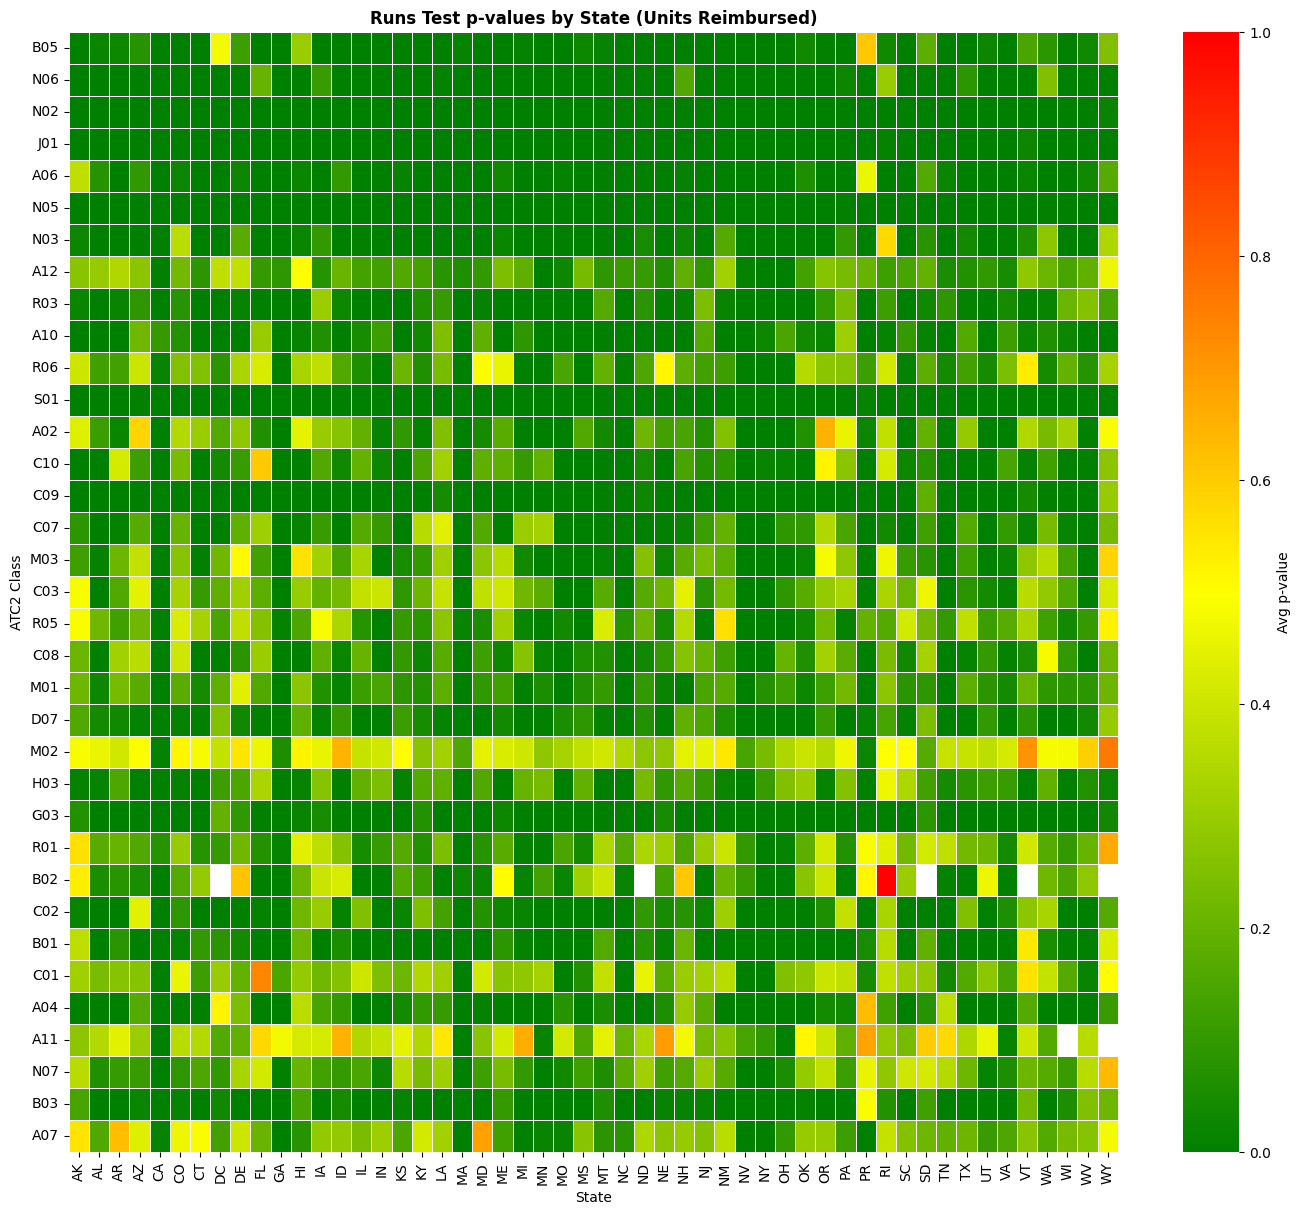

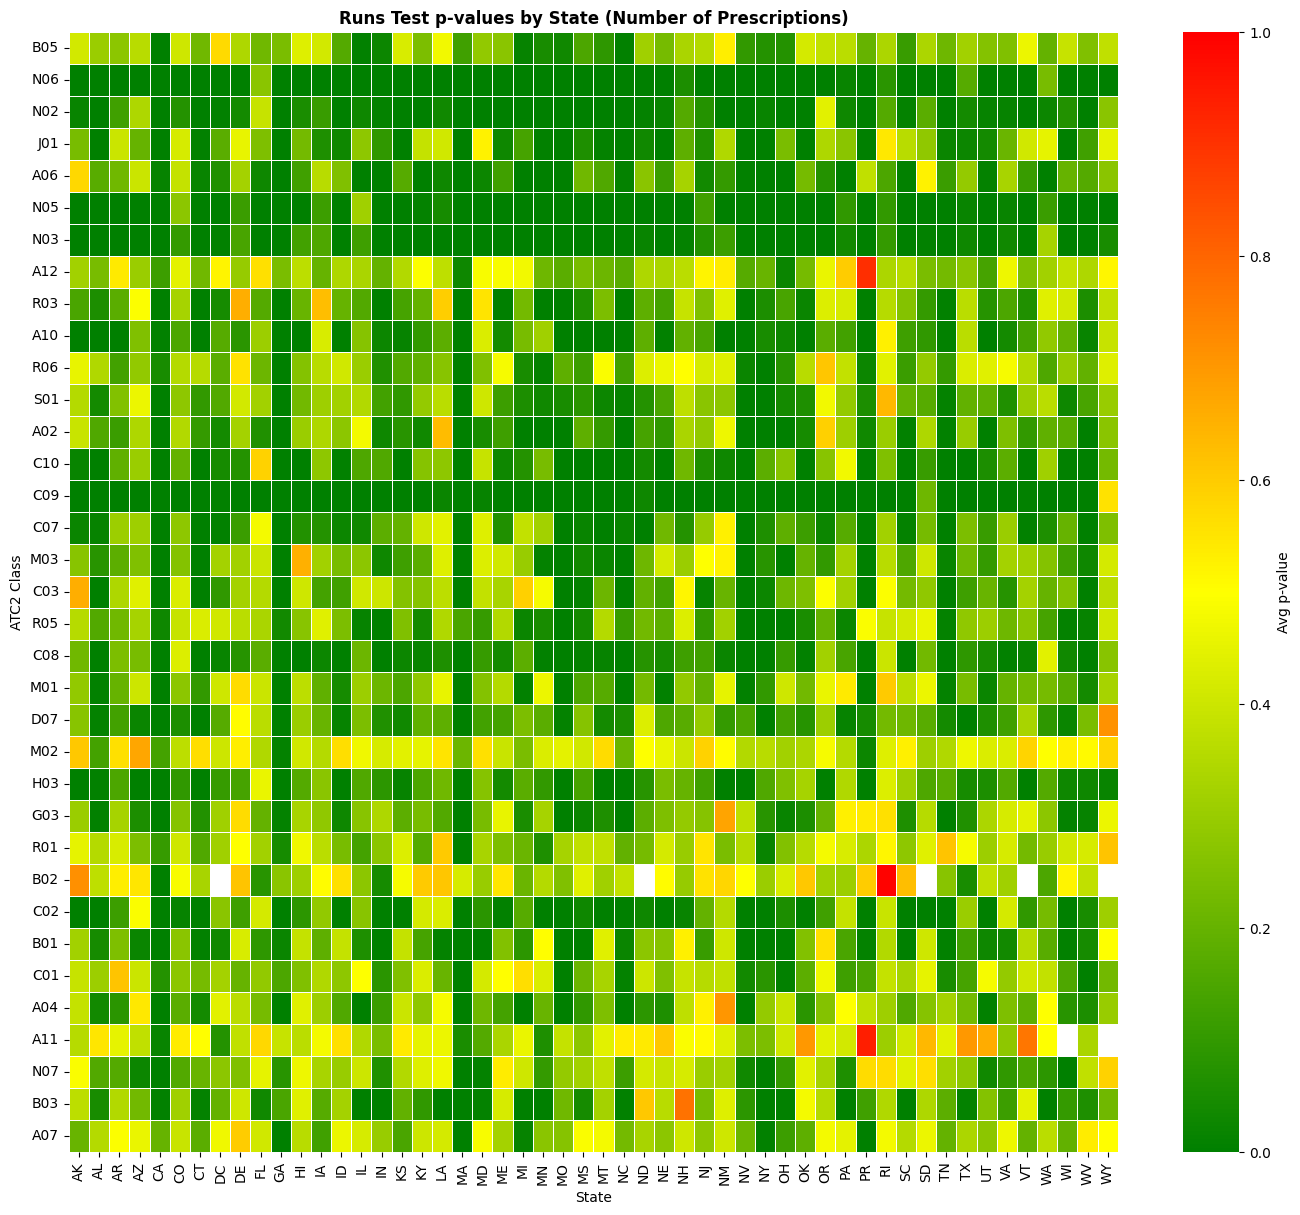

In [8]:

# Run the three-panel correlation analysis
# correlation_results = NDCATC_ind.correlation_look(years_list, min_records=25)

# Uncomment the line below to run the analysis
runs_results = NDCATC_ind.runs_test_analysis(years_list, min_records=25, generate_heatmaps=True, export_results=True)